In [1]:
import os

In [2]:
#have a glance at walkiebatch
def get_list(d):
    #replaces gen_list.py, load_listn, load_list. Use load_data_from_list on this output to get data.
    #returns train_list, test_list, where train_list[i] are the filenames of class i.
    #train_list[cend] are the filenames of the open class, if any. (OPEN_INSTNUM = 0 explicitly defines no open class)
    #get cstart, cend, ostart, oend. two ways to do so: with or without an explicit start.

    if "TRAIN_CINSTNUM" in d.keys():
        return get_list_with_sizes(d) #divert to other function
    
    if "CLOSED_SITESTART" in d.keys():
        cstart = d["CLOSED_SITESTART"]
        cend = d["CLOSED_SITEEND"]
    else:
        cstart = 0
        cend = d["CLOSED_SITENUM"]

    if "OPEN_INSTSTART" in d.keys():
        ostart = d["OPEN_INSTSTART"]
        oend = d["OPEN_INSTEND"]
    else:
        ostart = 0
        oend = d["OPEN_INSTNUM"]

    reqs = ["CLOSED_INSTNUM", "DATA_LOC", "FOLD_MODE", "FOLD_NUM", "DATA_TYPE"]
    for req in reqs:
        if not req in d.keys():
            raise Exception("{} not found in options.".format(req))

    iend = d["CLOSED_INSTNUM"]

    #default 10-fold. (Not much reason to change this.)

    if ("FOLD_TOTAL" in d):
        foldtotal = d["FOLD_TOTAL"]
    else:
        foldtotal = 10

    train_list = []
    test_list = []
    for i in range(cend):
        train_list.append([])
        test_list.append([])
    if oend != 0:
        train_list.append([])
        test_list.append([])

    #different modes
    #MODE 2: trainlist = testlist, according to parameters
    #MODE 3: standard X-fold. trainlist != testlist: testlist is fold ~X, trainlist is fold X (len(testlist) << len(trainlist))
    #MODE 4: trainlist != testlist: testlist is fold X, trainlist is fold X+1 (len(trainlist) == len(testlist))
        #for final set, testlist is fold X+1, trainlist is fold X

    if (d["FOLD_MODE"] == 2):
        for s in range(cstart, cend):
            for i in range(0, iend):
                sname = d["DATA_LOC"] + str(s) + "-" + str(i) + "." + d["DATA_TYPE"]
                train_list[s].append(sname)
                test_list[s].append(sname)
        for s in range(ostart, oend):
            sname = d["DATA_LOC"] + str(s) + "." + d["DATA_TYPE"]
            train_list[-1].append(sname)
            test_list[-1].append(sname)

    if (d["FOLD_MODE"] == 3):
        for s in range(cstart, cend):
            for i in range(0, iend):
                sname = d["DATA_LOC"] + str(s) + "-" + str(i) + "." + d["DATA_TYPE"]
                if (i >= d["CLOSED_INSTNUM"]/foldtotal * d["FOLD_NUM"] and
                    i < d["CLOSED_INSTNUM"]/foldtotal * (d["FOLD_NUM"]+1)):
                    test_list[s].append(sname)
                else:
                    train_list[s].append(sname)
        for s in range(ostart, oend):
            sname = d["DATA_LOC"] + str(s) + "." + d["DATA_TYPE"]
            if (s >= (oend-ostart)/foldtotal * d["FOLD_NUM"] + ostart and
                s < (oend-ostart)/foldtotal * (d["FOLD_NUM"]+1) + ostart):
                test_list[-1].append(sname)
            else:
                train_list[-1].append(sname)

    if (d["FOLD_MODE"] == 4):
        for s in range(cstart, cend):
            for i in range(0, iend):
                sname = d["DATA_LOC"] + str(s) + "-" + str(i) + "." + d["DATA_TYPE"]
                if (i >= d["CLOSED_INSTNUM"]/foldtotal * d["FOLD_NUM"] and
                    i < d["CLOSED_INSTNUM"]/foldtotal * (d["FOLD_NUM"]+1)):
                    test_list[s].append(sname)
        for s in range(ostart, oend):
            sname = d["DATA_LOC"] + str(s) + "." + d["DATA_TYPE"]
            if (s >= (oend-ostart)/foldtotal * d["FOLD_NUM"] + ostart and
                s < (oend-ostart)/foldtotal * (d["FOLD_NUM"]+1) + ostart):
                test_list[-1].append(sname)
        trainfoldnum = d["FOLD_NUM"] + 1
        if trainfoldnum >= foldtotal:
            trainfoldnum = d["FOLD_NUM"] - 1
        for s in range(cstart, cend):
            for i in range(0, d["CLOSED_INSTNUM"]):
                sname = d["DATA_LOC"] + str(s) + "-" + str(i) + "." + d["DATA_TYPE"]
                if (i >= d["CLOSED_INSTNUM"]/foldtotal * trainfoldnum and
                    i < d["CLOSED_INSTNUM"]/foldtotal * (trainfoldnum+1)):
                    train_list[s].append(sname)
        for s in range(ostart, oend):
            sname = d["DATA_LOC"] + str(s) + "." + d["DATA_TYPE"]
            if (s >= (oend-ostart)/foldtotal * trainfoldnum + ostart and
                s < (oend-ostart)/foldtotal * (trainfoldnum+1) + ostart):
                train_list[-1].append(sname)

    return train_list, test_list
def load_options(fname):
    d_options = {}
    f = open(fname, "r")
    lines = f.readlines()
    f.close()
    for line in lines:
        ignore = 0
        if (len(line) > 0):
            if line[0] == "#":
                ignore = 1
        if (ignore == 0 and "\t" in line):
            line = line[:-1]
            li = line.split("\t")
            d_options[li[0]] = read_value(li[1])
    return d_options

def read_value(string):
    if string[0] == "'" and string[-1] == "'":
        return string[1:-1]
    val = string
    try:
        val = int(string)
    except:
        try:
            val = float(string)
        except:
            pass
    return val


In [3]:

def load_cell(fname, time=0, ext=".cell"):
    #time = 0 means don't load packet times (saves time and memory)
    data = []
    time_stamp = []
    starttime = -1
    try:
        f = open(fname, "r")
        lines = f.readlines()
        f.close()

        if ext == ".htor":
            #htor actually loads into a cell format
            for li in lines:
                psize = 0
                if "INCOMING" in li:
                    psize = -1
                if "OUTGOING" in li:
                    psize = 1
                if psize != 0:
                    if time == 0:
                        data.append(psize)
                    if time == 1:
                        time = float(li.split(" ")[0])
                        if (starttime == -1):
                            starttime = time
                        data.append([time - starttime, psize])

        if ext == ".cell":
            for li in lines:
                li = li.split("\t")
                p = int(li[1])
                time_stamp.append(li[0])
                if time == 0:
                    data.append(p)
                if time == 1:
                    t = float(li[0])
                    if (starttime == -1):
                        starttime = t
                    data.append([t-starttime, p])
        if ext == ".burst":
            #data is like: 1,1,1,-1,-1\n1,1,1,1,-1,-1,-1
            for li in lines:
                burst = [0, 0]
                li = li.split(",")
                data.append([li.count("1"), li.count("-1")])
                for l in li:
                    if l == "1":
                        burst[0] += 1
                    if l == "-1":
                        burst[1] += 1
                data.append(burst)

        if ext == ".pairs":
            #data is like: [[3, 12], [1, 24]]
            #not truly implemented
            data = list(lines[0])            
    except:
        print "Could not load", fname
        sys.exit(-1)
    return time_stamp,data


In [4]:
optfname = 'options'
d = load_options(optfname)
X_train,X_test = get_list(d)

In [5]:
from collections import Counter
import matplotlib.pylab as plt
def io_graph(names,nums):
    plt.clf()
    plt.rcParams['figure.figsize'] = (18.0, 5.0)
    fit,axs = plt.subplots(1,nums)
    times = []
    for i in range(nums):
        io = []
        x_time,x_data = load_cell(names[i])
        times.append(x_time[-1])
        for k in x_time:
            io.append(int(float(k)))
        res = Counter(io)
        x = res.keys()
        y = res.values()            #plt.plot(x,y)
        axs[i].plot(x,y)
        axs[i].axis('off')
    times_flo=[]
    for i in times:
        times_flo.append(float(i))
    
    print 'graph:' + names[0] + '---->' + names[nums] 
    print 'load time::: min:{}, max:{}, avg:{}'.format(min(times_flo),max(times_flo),sum(times_flo)/nums)

graph:walkiebatch/0-1.cell---->walkiebatch/0-6.cell
load time::: min:6.92148590088, max:17.0479209423, avg:11.5255119801


<Figure size 432x288 with 0 Axes>

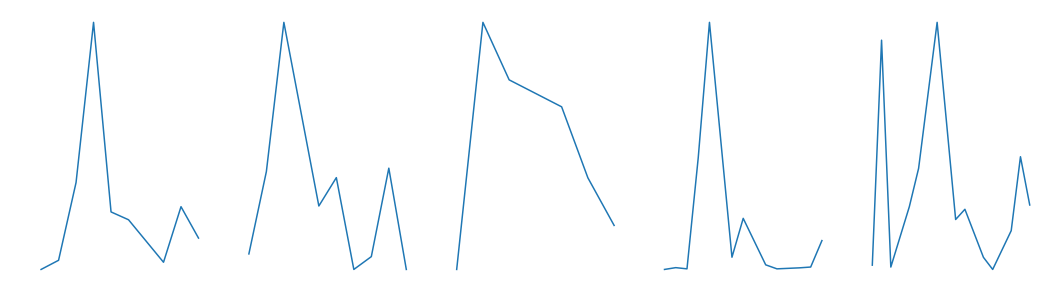

In [6]:
io_graph(X_train[0],5)

graph:walkiebatch/1-1.cell---->walkiebatch/1-6.cell
load time::: min:7.47133898735, max:29.4798660278, avg:16.6399869919


<Figure size 1296x360 with 0 Axes>

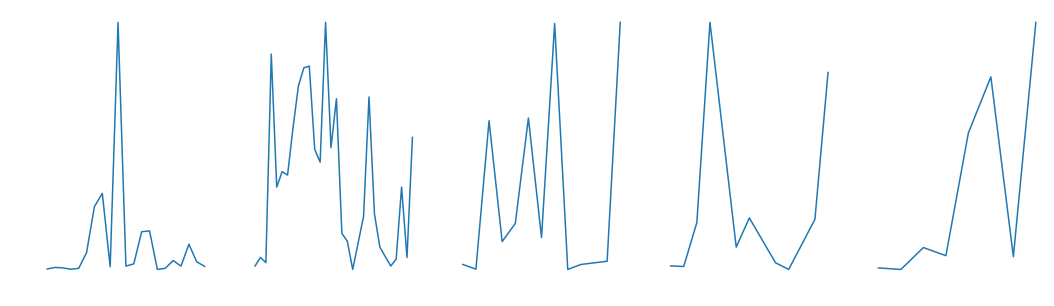

In [7]:
io_graph(X_train[1],5)

graph:walkiebatch/3-1.cell---->walkiebatch/3-6.cell
load time::: min:14.5057311058, max:48.6329391003, avg:35.3009428024


<Figure size 1296x360 with 0 Axes>

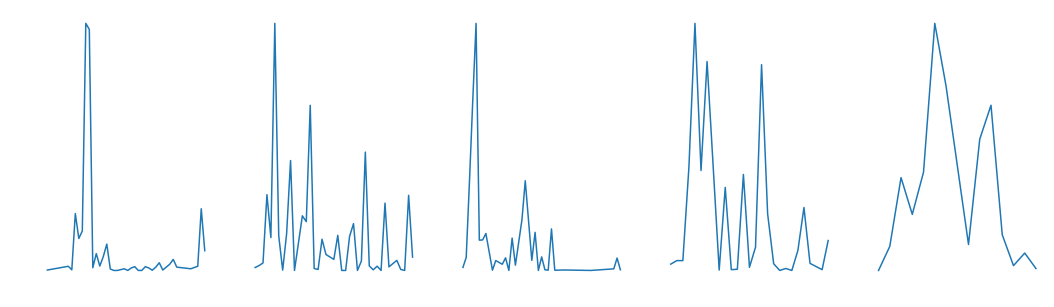

In [8]:
io_graph(X_train[3],5)

graph:walkiebatch/23-1.cell---->walkiebatch/23-6.cell
load time::: min:11.088971138, max:17.1867160797, avg:14.1056022167


<Figure size 1296x360 with 0 Axes>

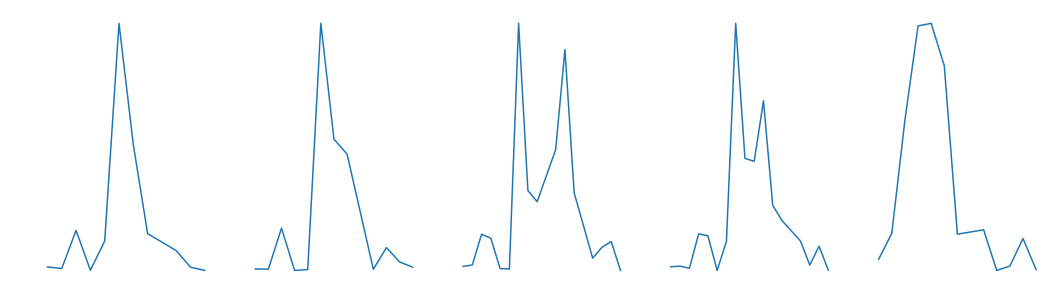

In [9]:
io_graph(X_train[23],5)

In [10]:
def seq_graph(names,nums):
    plt.clf()
    plt.rcParams['figure.figsize'] = (18.0, 5.0)
    fit,axs = plt.subplots(1,nums)
    times = []
    for i in range(nums):
        io = []
        io_in = []
        io_out = []
        x_time,x_data = load_cell(names[i])
        times.append(x_time[-1])
        for k,j in zip(x_time,x_data):
            io.append(int(float(k)))
            if j<0:
                io_in.append(int(float(k)))
            else:
                io_out.append(int(float(k)))
        res = Counter(io)
        res_in = Counter(io_in)
        res_out = Counter(io_out)
        x = res.keys()
        y = res.values() 
        x_in = res_in.keys()
        y_in = res_in.values()            #plt.plot(x,y)
        x_out = res_out.keys()
        y_out = res_out.values()
        axs[i].plot(x,y,c='g')
        axs[i].bar(x_in,y_in)
        axs[i].bar(x_out,y_out)
        axs[i].axis('off')
    times_flo=[]
    for i in times:
        times_flo.append(float(i))
    #print io_in
    #print io_out
    print 'graph:' + names[0] + '---->' + names[nums] 
    print 'load time::: min:{}, max:{}, avg:{}'.format(min(times_flo),max(times_flo),sum(times_flo)/nums)

graph:walkiebatch/0-1.cell---->walkiebatch/0-6.cell
load time::: min:6.92148590088, max:17.0479209423, avg:11.5255119801


<Figure size 1296x360 with 0 Axes>

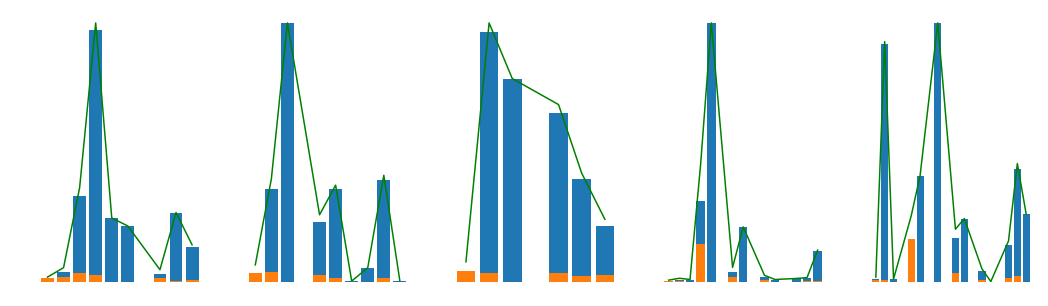

In [11]:
seq_graph(X_train[0],5)

graph:walkiebatch/1-1.cell---->walkiebatch/1-6.cell
load time::: min:7.47133898735, max:29.4798660278, avg:16.6399869919


<Figure size 1296x360 with 0 Axes>

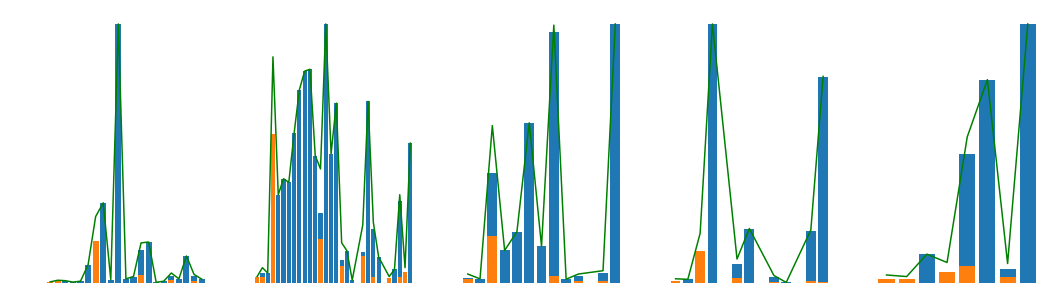

In [12]:
seq_graph(X_train[1],5)

graph:walkiebatch/3-1.cell---->walkiebatch/3-6.cell
load time::: min:14.5057311058, max:48.6329391003, avg:35.3009428024


<Figure size 1296x360 with 0 Axes>

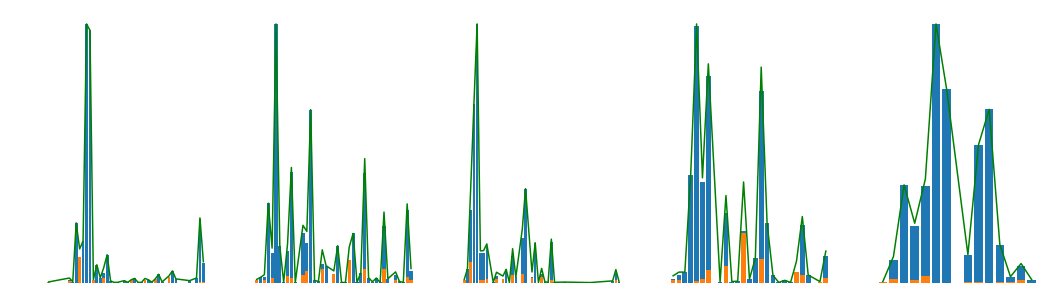

In [13]:
seq_graph(X_train[3],5)